# Test Shallow Water Physics on a mesh
Forward Euler and forward backward integrators are tested and compared on a hexagonal mesh loaded from a file

In [1]:
include("mode_forward/time_steppers.jl")
include("mode_init/MPAS_Ocean.jl")
include("visualization.jl")

using PyPlot
using PyCall

patch = pyimport("matplotlib.patches")
col = pyimport("matplotlib.collections")
animation = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")

PyObject <module 'IPython.display' from '/home/rrs/anaconda3/envs/MPAS_Ocean/lib/python3.8/site-packages/IPython/display.py'>

## load mesh from a file

In [2]:
mpasOcean = MPAS_Ocean(false, 
                "MPAS_O_Shallow_Water/Mesh+Initial_Condition+Registry_Files/Periodic",
                "base_mesh.nc",
                "mesh.nc")
nothing

## define dt, duration of the simulation, number of snapshots of the sea surface height to record, and arrays for recording it

# Run the simulation

In [3]:
include("mode_init/initial_conditions.jl")

planeWaveInit! (generic function with 1 method)

## integrate with forward euler

In [86]:
gaussianInit!(mpasOcean; sx=0.07, sy=0.07, mx=0.5, my=0.6)

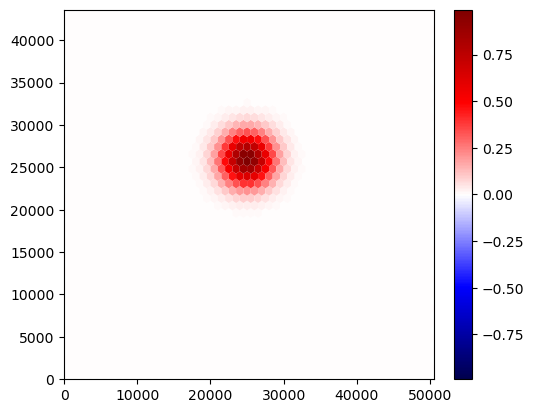

In [87]:
fig, ax = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
display(fig)

In [84]:
nFrames = 40

stepsBetweenFrames = 3

"dt: ", mpasOcean.dt

("dt: ", 1.0101525445522077)

In [29]:
# solve it, integrate!
## forward euler
sshOverTimeFE = zeros(Float64, (nFrames, mpasOcean.nCells))

for frame in 1:nFrames
    for i in 1:stepsBetweenFrames
        forward_euler_step!(mpasOcean)
    end
    sshOverTimeFE[frame,:] = mpasOcean.sshCurrent[:]
end

## animate forward euler solution

In [30]:
fig = figure()

cMax = maximum(abs.(sshOverTimeFE))

_, ax, _, collection = heatMapMesh(mpasOcean, sshOverTimeFE[1,:], fig=fig, cMin=-cMax, cMax=cMax)

function nextFrame(j)
    i = j + 1
    
    collection.set_array(sshOverTimeFE[i,:])
    
    return ax
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7fbc9bee09d0>

In [31]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

In [38]:
mplot3d = pyimport("mpl_toolkits.mplot3d")
Axes3D = mplot3d.Axes3D

PyObject <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>

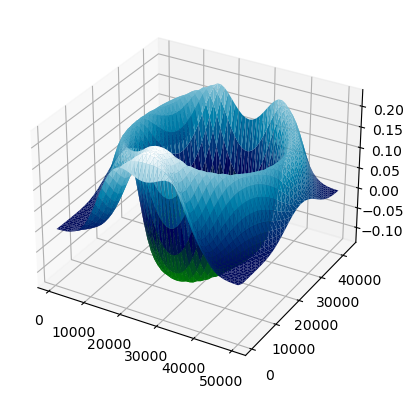

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fbc980bb760>

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
r(x) = x#reshape(x, (50,50))
ax.plot_trisurf(r(mpasOcean.xCell), r(mpasOcean.yCell), r(mpasOcean.sshCurrent), edgecolor="none", cmap="ocean")

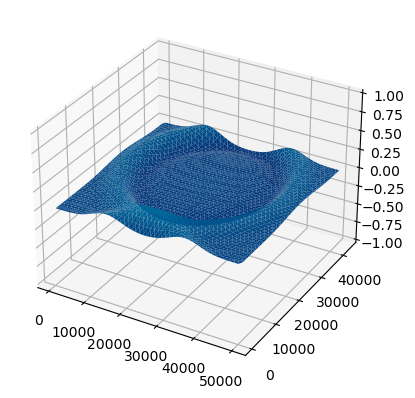

PyObject <matplotlib.animation.FuncAnimation object at 0x7fbc62c3adf0>

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
r(x) = reshape(x, (50,50))

ax.set_zlim(-1,1)

cMax = maximum(abs.(sshOverTimeFB))

surf = ax.plot_trisurf(mpasOcean.xCell, mpasOcean.yCell, sshOverTime,
        edgecolor="none", cmap="ocean", vmin=-1, vmax=1)


function nextFrame(j)
    i = j + 1
    
    ax.clear()
    ax.set_zlim(-1,1)
    cMax = maximum(abs.(sshOverTimeFB[i,:]))*1.1
    surf = ax.plot_trisurf(mpasOcean.xCell, mpasOcean.yCell, sshOverTimeFB[i,:],
                edgecolor="none", cmap="ocean", vmin=-cMax, vmax=cMax)    
    
    return ax
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

In [94]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

In [72]:
# anim.save("plots/test1/forwardeuler_ssh_test1.mp4")
# ipydisplay.Video("plots/test1/forwardeuler_ssh_test1.mp4")

## reset simulation and run with forward backward solver

In [88]:
# reset
gaussianInit!(mpasOcean; sx=0.07, sy=0.07, mx=0.5, my=0.6)

sshOverTimeFB = zeros(Float64, (nFrames, mpasOcean.nCells))

for frame in 1:nFrames
    for j in 1:5
        forward_backward_step!(mpasOcean)
    end
    sshOverTimeFB[frame,:] = mpasOcean.sshCurrent[:]
end

# Compare forward euler and forward backward with side-by-side animations

In [12]:
fig = figure()

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

cMax1 = maximum(abs.(sshOverTimeFE))
cMax2 = maximum(abs.(sshOverTimeFB))
cMax3 = maximum(abs.(sshOverTimeFE .- sshOverTimeFB))


_, _, _, col1 = heatMapMesh(mpasOcean, sshOverTimeFE[1,:]; fig=fig, ax=ax1, cMin=-cMax1, cMax=cMax1)
ax1.set_title("Forward Euler")
ax1.axis("off")

_, _, _, col2 = heatMapMesh(mpasOcean, sshOverTimeFB[1,:]; fig=fig, ax=ax2, cMin=-cMax2, cMax=cMax2)
ax2.set_title("Forward Backward")
ax2.axis("off")

_, _, _, col3 = heatMapMesh(mpasOcean, sshOverTimeFE[1,:] .- sshOverTimeFB[1,:]; fig=fig, ax=ax3, cMin=-cMax3, cMax=cMax3)
ax3.set_title("Difference")
ax3.axis("off")


tight_layout()

function nextFrame(j)

    i = j+1

    col1.set_array(sshOverTimeFE[i,:])
    col2.set_array(sshOverTimeFB[i,:])
    col3.set_array(sshOverTimeFE[i,:] - sshOverTimeFB[i,:])

    fig.suptitle("frame $j of $nFrames")

    return [ax1, ax2, ax3]

end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7fbc9bde6e80>

In [13]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

In [18]:
# anim.save("plots/test2/forwardeuler_vs_forwardbackward.mp4")
# ipydisplay.Video("plots/test2/forwardeuler_vs_forwardbackward.mp4")